# Tutorial: data integration for PBMC data (10x Genomics Visium)

In this tutorial, we demonstrate how to apply FGOT to PBMC data with exchaged X1, X2 in function fgot_sparse_tensor(). The results show that the effect of this function is independent of direction.

## load package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import scanpy as sc
from anndata import AnnData
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
import sys
sys.path.insert(1, '/home/nas2/biod/yangchenghui/FGOT-master')
import FGOT
from FGOT import preprocess as pre
from FGOT import fgot_sparse_tensor, fgot_tol, align
from FGOT import metrics as mt

## load data

In [3]:
data_path = "/home/nas2/biod/yangchenghui/FGOT-master/data/PBMC_data/"
RNA_data = pd.read_csv(data_path+'feature_selected_RNA_normalized.txt', sep='\t', index_col=0)
ATAC_data = pd.read_csv(data_path+'feature_250kb_ATAC_normalized.txt', sep='\t', index_col=0)

RNA_cluster = pd.read_csv(data_path+'label.txt', sep='\t').rename(columns={'Unnamed: 0': 'cell', 'metas': 'cluster'})
ATAC_cluster = RNA_cluster

In [4]:
X1 = ATAC_data.T
X2 = RNA_data.T
(n1, d1) = X1.shape
(n2, d2) = X2.shape
print("Dimensions of input datasets are: ", "X1 = ", X1.shape, " X2 = ", X2.shape)
basic_labels1 = np.array(ATAC_cluster['cluster'])
basic_labels2 = np.array(RNA_cluster['cluster'])
print("Dimensions of basic_labels are: ", "basic_labels1 = ", basic_labels1.shape, " basic_labels2 = ", basic_labels2.shape)
cell_names1 = list(ATAC_data.columns)
cell_names2 = list(RNA_data.columns)
peak_names = list(ATAC_data.index)
gene_names = list(RNA_data.index)

Dimensions of input datasets are:  X1 =  (3197, 7835)  X2 =  (3197, 215)
Dimensions of basic_labels are:  basic_labels1 =  (3197,)  basic_labels2 =  (3197,)


## build a priori feature graph

In [5]:
promoters = pd.read_csv(data_path+'hg38.promoter.regions.txt', sep = '\t')
promoters.head()

,chr,starts,ends,genes
1,chr1,12623,12624.0,DDX11L1
2,chr1,30120,30121.0,WASH7P
3,chr1,18186,18187.0,MIR6859.1
4,chr1,18186,18187.0,MIR6859.2
5,chr1,18186,18187.0,MIR6859.3


In [6]:
feature_matrix = pre.prior_feature_graph(promoters, peak_names, gene_names)
feature_matrix

0it [00:00, ?it/s]

72337it [00:00, 78997.47it/s] 
41399it [00:01, 22965.86it/s]
100%|██████████| 215/215 [00:02<00:00, 89.97it/s] 


The number of gene nodes, peak nodes, and edges in the prior feature graph is: 215 7835 9115


100%|██████████| 9115/9115 [00:00<00:00, 402601.95it/s]


,NIPAL3,RCAN3AS,RCAN3,HYI,CD52,GAS5,LINC01135,COL24A1,RPL5,DIPK1A,...,PRKCH,PTGDR,GZMH,TNFAIP2,CEP128,TCF4,BCL2,LINC01478,SETBP1,TTC39C
chr17-48456637-48457880,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr16-3011951-3014525,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr19-54434338-54435688,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr19-35484675-35485088,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr1-160284015-160285824,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr19-18414123-18442655,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr12-31705380-31706105,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr18-55778545-55781183,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,1.0,inf,inf,inf,inf
chr10-70363713-70365125,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


## compute cost across modalities

We use wnn to calculate cost for paired data.

In [7]:
wnn = pd.read_csv(data_path+'PBMC_wnn.txt', sep='\t', index_col=0)
wnn

,Agg_1,Agg_2,Agg_3,Agg_4,Agg_5,Agg_6,Agg_7,Agg_8,Agg_9,Agg_10,...,Agg_3192,Agg_3193,Agg_3194,Agg_3195,Agg_3196,Agg_3197,Agg_3198,Agg_3199,Agg_3200,Agg_3201
Agg_1,1.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Agg_2,0.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Agg_3,0.0,0.0,1.000000,0.176471,0.0,0.0,0.000000,0.000000,0.081081,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Agg_4,0.0,0.0,0.176471,1.000000,0.0,0.0,0.000000,0.000000,0.379310,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Agg_5,0.0,0.0,0.000000,0.000000,1.0,0.0,0.111111,0.176471,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Agg_3197,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.538462,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.212121,0.000000
Agg_3198,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.176471,0.081081,0.212121,0.000000,1.000000,0.379310,0.000000,0.176471
Agg_3199,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.250000,0.000000,0.428571,0.142857,0.538462,0.000000,0.379310,1.000000,0.000000,0.481481
Agg_3200,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.176471,0.142857,0.000000,0.250000,0.000000,0.212121,0.000000,0.000000,1.000000,0.000000


In [8]:
cost = np.array(np.exp(1 - wnn))
cost = cost - np.min(cost)
cost = pd.DataFrame(cost, index = cell_names1, columns=cell_names2)

Text(0.5, 1.0, 'cost across modality')

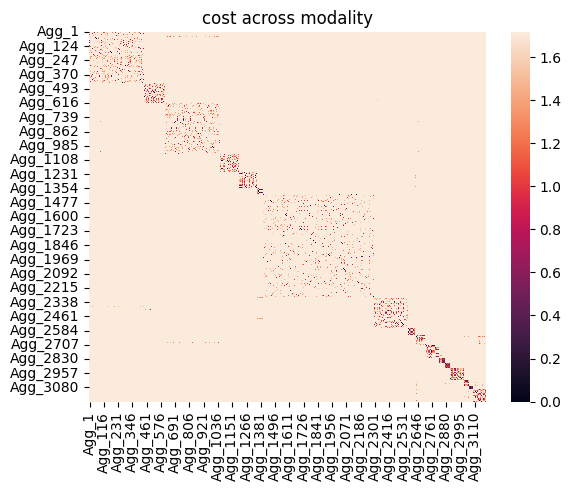

In [9]:
sns.heatmap(cost)
pl.title('cost across modality')

## scale

In [10]:
scaler = StandardScaler()
X1, X2 = scaler.fit_transform(X1), scaler.fit_transform(X2)
X1 = pd.DataFrame(X1,index= cell_names1,columns=peak_names)
X2 = pd.DataFrame(X2,index= cell_names2,columns=gene_names)

## solve the feature-guided optimal transport problem

In [11]:
P_tensor = fgot_sparse_tensor(X2, X1, feature_matrix.T, cost.T, RNA_cluster, ATAC_cluster,\
    minibatch=1, batchsize=500, pair = True, device='cuda:2', eps_p = 1e-1)

minibatch = 1 and device =  cuda:2
the total number of computing batch is  6


100%|██████████| 6/6 [1:18:05<00:00, 780.94s/it]


## make multi-omics alignment from the transport tensor

In [12]:
P = fgot_tol(P_tensor)
P.shape

100%|██████████| 9115/9115 [10:48<00:00, 14.06it/s]


(3197, 3197)

Text(0.5, 1.0, 'optimal transport matrix')

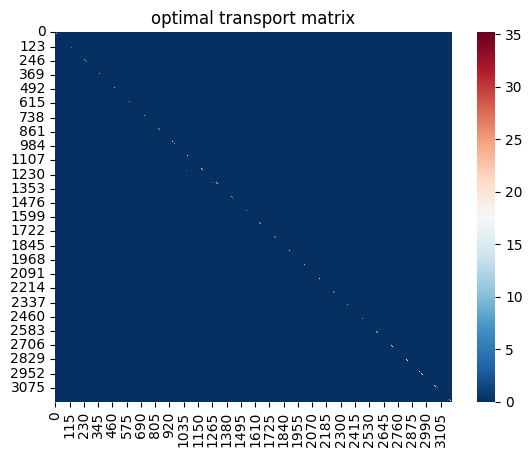

In [13]:
sns.heatmap(P, cmap="RdBu_r")
pl.title('optimal transport matrix')

In [14]:
X1_aligned, X2_aligned = align(X1, X2, P)

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterp

[<Axes: title={'center': 'batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'label'}, xlabel='UMAP1', ylabel='UMAP2'>]

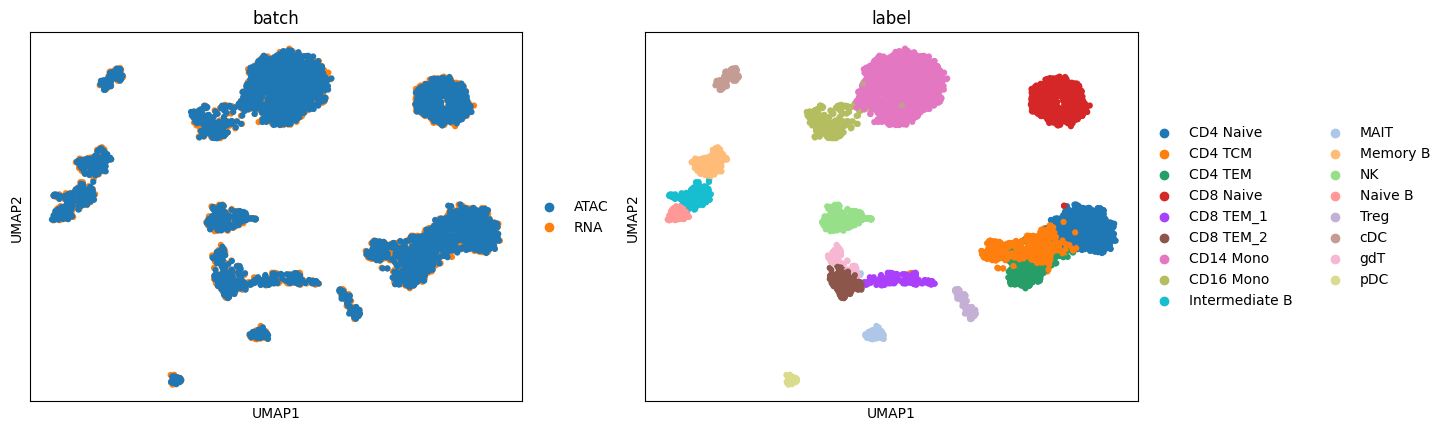

In [15]:
data_aligned = np.concatenate((X2_aligned, X1_aligned), axis=0)
adata_aligned = AnnData(data_aligned)
adata_aligned.obs['batch'] = np.array(['RNA'] * n2 + ['ATAC'] * n1)
adata_aligned.obs['label'] = np.concatenate((basic_labels2, basic_labels1),axis=0)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)
sc.pl.umap(adata_aligned, color=['batch', 'label'],s = 80, show=False)

In [16]:
RNA_umap = np.array(adata_aligned[adata_aligned.obs['batch'] == 'RNA'].obsm['X_umap'])
RNA_label = np.array(adata_aligned[adata_aligned.obs['batch'] == 'RNA'].obs['label'])
ATAC_umap = np.array(adata_aligned[adata_aligned.obs['batch'] == 'ATAC'].obsm['X_umap'])
ATAC_label = np.array(adata_aligned[adata_aligned.obs['batch'] == 'ATAC'].obs['label'])
from sklearn.neighbors import KNeighborsClassifier
k = len(np.unique(RNA_label))
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(RNA_umap, RNA_label)
ATAC_predict = knn.predict(ATAC_umap)

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, f1_score
ari = adjusted_rand_score(ATAC_label, ATAC_predict)
nmi = normalized_mutual_info_score(ATAC_label, ATAC_predict)
f1 = f1_score(ATAC_label, ATAC_predict, average='weighted')
print('ARI score: '+str(ari))
print('NMI score: '+str(nmi))
print('f1 Loss: '+str(f1))

print("transfer accuracy: "+str(mt.test_transfer_accuracy(ATAC_umap,RNA_umap,ATAC_label,RNA_label)))
# FOSCTTM_score = mt.calc_domainAveraged_FOSCTTM(RNA_umap,ATAC_umap)
silhouette_score = mt.silhouette(adata_aligned.obsm['X_umap'],np.array(adata_aligned.obs['label']))
batch_entropy_mixing_score = mt.batch_entropy_mixing_score(adata_aligned.obsm['X_umap'],np.array(adata_aligned.obs['batch']))

# print('FOSCTTM score: '+str(FOSCTTM_score))
print('Silhouette score: '+str(silhouette_score))
print('Batch Entropy score: '+str(batch_entropy_mixing_score))

ARI score: 0.9643352711583297
NMI score: 0.95564105454435
f1 Loss: 0.9755393894581892
transfer accuracy: 0.9621520175164217
Silhouette score: 0.7785097658634186
Batch Entropy score: 0.6922422338076344
